In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 23.0 MB/s eta 0:00:00


In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torch
from torch.utils.data import Dataset
import time
from tqdm import tqdm
from torchmetrics import Accuracy, F1Score, Precision, Recall, MetricCollection
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import torch.optim as optim

In [3]:
class TripletLoss(nn.Module):

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        euc_distance_positive = (anchor - positive).pow(2).sum(1)
        euc_distance_negative = (anchor - negative).pow(2).sum(1)
        losses = F.relu(euc_distance_positive - euc_distance_negative + self.margin)
        return losses.mean()

In [4]:
class DeepArchitecture(nn.Module):
    def __init__(self, embed_size):
        super(DeepArchitecture, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, embed_size))

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output


class FaceNet(nn.Module):
    def __init__(self, embed_size):
        super(FaceNet, self).__init__()
        self.deep_arch = DeepArchitecture(embed_size=embed_size)

    def l2_norm(self, input):
        input_size = input.size()
        buffer = torch.pow(input, 2)
        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)
        _output = torch.div(input, norm.view(-1, 1).expand_as(input))
        output = _output.view(input_size)
        return output


    def forward(self, x1, x2, x3):
        output1 = self.deep_arch(x1)
        output2 = self.deep_arch(x2)
        output3 = self.deep_arch(x3)
        output1 = self.l2_norm(output1)
        output2 = self.l2_norm(output2)
        output3 = self.l2_norm(output3)
        return output1, output2, output3

In [5]:
def get_dataloaders(train_dataset, val_dataset, dataloader_workers: int = 2, batch_size: int = 8):
    
    kwargs = {'pin_memory': True, 'num_workers': dataloader_workers}
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        **kwargs
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        drop_last=False,
        shuffle=False,
        **kwargs
    )
    return {'train': train_loader, 'val': val_loader}

def get_test_dataloaders(test_dataset, dataloader_workers: int = 2, batch_size: int = 8):
    """
    Get Dataloaders for the given dataset.
    @param test_dataset The dataset to wrap into a Dataloader
    @param dataloader_workers How many workers to give each Dataloader.
    @param batch_size Batch Size
    """

    kwargs = {'pin_memory': True, 'num_workers': dataloader_workers}
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        **kwargs
    )
    return test_loader

In [6]:
def calc_loss(anchor, positive, negative, loss_fn):
    loss = loss_fn(anchor, positive, negative)
    return loss

In [7]:
def plot_training(total_loss):
    plt.plot(total_loss["train"], color='blue')
    plt.title("Loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train_loss'])
    plt.show()

In [8]:
def train_model(model, dataloaders, loss_func, optimizer_func, use_cuda, epochs, num_class, checkpoint_path_model = "/content/chckpnt", trained_epochs: int = 0, tb_writer = None):
    best_loss = 1e10
    total_acc = {key: [] for key in ['train', 'val']}
    total_loss = {key: [] for key in ['train', 'val']}
    loss_fn = loss_func
    optimizer = optimizer_func
    since = time.time()

    metrics = MetricCollection([
        Accuracy(task="multiclass", num_classes=num_class, mdmc_average="global"),
        F1Score(task="multiclass", num_classes=num_class, mdmc_average="global"),
        Precision(task="multiclass", num_classes=num_class, mdmc_average="global"),
        Recall(task="multiclass", num_classes=num_class, mdmc_average="global")
    ])

    train_metrics = metrics.clone(prefix="train")
    val_metrics = metrics.clone(prefix="val")

    # iterate over all epochs
    for epoch in range(trained_epochs, epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0
            for dic in tqdm(dataloaders[phase], total=len(dataloaders[phase])):
                inputs, labels = dic

                if use_cuda:
                    inputs = list(inps.cuda() for inps in inputs) # [batch_size, in_channels, H, W]
                    labels = (lbls.cuda() for lbls in labels)

                optimizer.zero_grad()  # zero the parameter gradients

                # forward pass: compute prediction and the loss btw prediction and true label
                # track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(*inputs)
                    
                    # output is binary [batch size, n_classes, H, W], target is class [batch size, 1, H, W]
                    loss = calc_loss(*outputs, loss_fn)

                    # backward + optimize only if in training phase (no need for torch.no_grad in this training pass)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss * outputs[0].shape[0]
                #preds_cpu = torch.tensor(*(outs.cpu() for outs in outputs))
                #labels_cpu = torch.tensor(*(lbls.cpu() for lbls in labels))
                #if phase == "train":
                    #train_metrics.update(preds_cpu, labels_cpu)
                #elif phase == "val":
                    #val_metrics.update(preds_cpu, labels_cpu)

            if phase == "train":
                computed_metrics = train_metrics.compute()
                train_metrics.reset()
            elif phase == "val":
                computed_metrics = val_metrics.compute()
                val_metrics.reset()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            computed_metrics[f"{phase}Loss"] = epoch_loss

            epoch_summary = f'Epoch {phase} : {epoch+1}'
            for k, v in computed_metrics.items():
              epoch_summary = f"{epoch_summary}\n\t{k} : {v:.6f}"

            print(epoch_summary)

            #total_acc[phase].append(computed_metrics[f"{phase}Accuracy"].item())
            total_loss[phase].append(computed_metrics[f"{phase}Loss"].item())

        
            # Display metrics in Tensorboard
            if tb_writer is not None:
                for item in ["Loss", "Accuracy", "F1Score", "Precision", "Recall"]:
                    tb_writer.add_scalar(f"{item}/{phase}", computed_metrics[f"{phase}{item}"], epoch)

            # save the model weights in validation phase 
            if phase == 'val':
                if epoch_loss < best_loss:
                    print(f"saving best model to {checkpoint_path_model}")
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), checkpoint_path_model)

        # Display total time
        time_elapsed = time.time() - since
        print('Total time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    plot_training(total_loss) #, total_acc)

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path_model))

    return model

In [9]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



In [10]:
from PIL import Image

class TripletMNIST(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1, label1 = self.test_data[self.test_triplets[index][0]], self.test_labels[self.test_triplets[index][0]].item()
            img2 = self.test_data[self.test_triplets[index][1]]
            img3, negative_label = self.test_data[self.test_triplets[index][2]], self.test_labels[self.test_triplets[index][2]].item()

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        img3 = Image.fromarray(img3.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3), (label1, negative_label)

    def __len__(self):
        return len(self.mnist_dataset)

In [11]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
dataloaders = get_dataloaders(triplet_train_dataset, triplet_test_dataset, batch_size=batch_size)
test_set = get_test_dataloaders(triplet_test_dataset, batch_size=batch_size)

margin = 1.
model = FaceNet(embed_size=128)
if torch.cuda.is_available():
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
wd = 1e-5
optimizer = optim.Adam(params=model.parameters(), lr=lr, weight_decay=wd)
n_epochs = 5

/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Epoch 1/5
----------


100%|██████████| 469/469 [01:00<00:00,  7.80it/s]
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MulticlassF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MulticlassPrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``com

Epoch train : 1
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.048903


100%|██████████| 79/79 [00:05<00:00, 13.56it/s]


Epoch val : 1
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.016964
saving best model to /content/chckpnt
Total time elapsed: 1m 6s
Epoch 2/5
----------


100%|██████████| 469/469 [00:49<00:00,  9.42it/s]


Epoch train : 2
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.013004


100%|██████████| 79/79 [00:07<00:00, 10.31it/s]


Epoch val : 2
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.011937
saving best model to /content/chckpnt
Total time elapsed: 2m 4s
Epoch 3/5
----------


100%|██████████| 469/469 [00:50<00:00,  9.37it/s]


Epoch train : 3
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.009438


100%|██████████| 79/79 [00:08<00:00,  8.96it/s]


Epoch val : 3
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.010039
saving best model to /content/chckpnt
Total time elapsed: 3m 2s
Epoch 4/5
----------


100%|██████████| 469/469 [00:50<00:00,  9.20it/s]


Epoch train : 4
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.007956


100%|██████████| 79/79 [00:06<00:00, 12.24it/s]


Epoch val : 4
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.009780
saving best model to /content/chckpnt
Total time elapsed: 3m 60s
Epoch 5/5
----------


100%|██████████| 469/469 [00:50<00:00,  9.23it/s]


Epoch train : 5
	trainMulticlassAccuracy : 0.000000
	trainMulticlassF1Score : 0.000000
	trainMulticlassPrecision : 0.000000
	trainMulticlassRecall : 0.000000
	trainLoss : 0.005919


100%|██████████| 79/79 [00:06<00:00, 13.11it/s]


Epoch val : 5
	valMulticlassAccuracy : 0.000000
	valMulticlassF1Score : 0.000000
	valMulticlassPrecision : 0.000000
	valMulticlassRecall : 0.000000
	valLoss : 0.006608
saving best model to /content/chckpnt
Total time elapsed: 4m 57s
Best val loss: 0.006608


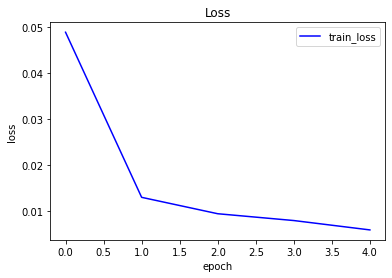

FaceNet(
  (deep_arch): DeepArchitecture(
    (convnet): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU(num_parameters=1)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=256, out_features=128, bias=True)
    )
  )
)

In [12]:
train_model(model, dataloaders, loss_fn, optimizer, torch.cuda.is_available(), n_epochs, n_classes)

7 & 3
Diff_first: 0.26
Diff_second: 1.58


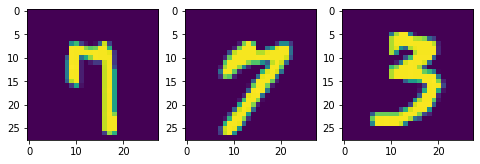

In [18]:
result = []
threshold = 1.0
fig = plt.figure(figsize=(8, 8))

model.eval()
with torch.no_grad():
      inputs, labels = test_set.dataset[80]
      if torch.cuda.is_available():
        inputs = list(torch.unsqueeze(inps, 0).cuda() for inps in inputs) # [batch_size, in_channels, H, W]
        labels = list(labels)
      embed1, embed2, embed3 = model(*inputs)
      concatenated = torch.cat((inputs[0][0], inputs[1][0], inputs[2][0]),0)
      euclidean_distance = F.pairwise_distance(embed1, embed2)
      euclidean_distance2 = F.pairwise_distance(embed1, embed3)
      name1, name2 = labels[0], labels[1]
      not_same = euclidean_distance > threshold
      diff_class = int(labels[0] != labels[1])
      pred = ("same", "diff")[not_same]
      text = f"{name1} & {name2}\nDiff_first: {euclidean_distance.item():.2f}\nDiff_second: {euclidean_distance2.item():.2f}"
      print(text)
      fig.add_subplot(1,3,1)
      plt.imshow(concatenated[0].cpu())
      fig.add_subplot(1,3,2)
      plt.imshow(concatenated[1].cpu())
      fig.add_subplot(1,3,3)
      plt.imshow(concatenated[2].cpu())
#plt.savefig('test-result.png')
plt.show()

In [19]:
correct_labels = 0
dataSize = 10000
for idx in range(dataSize):
  model.eval()
  with torch.no_grad():
        inputs, labels = test_set.dataset[idx]
        if torch.cuda.is_available():
          inputs = list(torch.unsqueeze(inps, 0).cuda() for inps in inputs) # [batch_size, in_channels, H, W]
          labels = list(labels)
        embed1, embed2, embed3 = model(*inputs)
        concatenated = torch.cat((inputs[0][0], inputs[1][0], inputs[2][0]),0)
        euclidean_distance = F.pairwise_distance(embed1, embed2)
        euclidean_distance2 = F.pairwise_distance(embed1, embed3)
        if euclidean_distance < euclidean_distance2:
          correct_labels += 1
print(f"Number of images that gave smaller distance than the randomly chosen negative pair: {correct_labels} out of {dataSize} images")

Number of images that gave smaller distance than the randomly chosen negative pair: 9981 out of 10000 images
